# Sample Clarius Analysis

# Select Image & Phantom and Parse

In [15]:
from pyquantus.parse.clarius import clariusRfParser

rf_path = '/Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_rf.raw'
rf_tgc_path = '/Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_env.tgc.yml'
info_path = '/Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_rf.yml'

imgData, imgInfo, refData, refInfo = clariusRfParser(rf_path, rf_tgc_path, info_path,
                                                    rf_path, rf_tgc_path, info_path)

The number of missing timestamps for /Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_env.tgc.yml is: 30. Skipping this scan with current criteria.
A default TGC matrix of size (192, 2928, 30) is generated.
A default TGC matrix of size (192, 2928, 30) is generated.
The number of missing timestamps for /Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_env.tgc.yml is: 30. Skipping this scan with current criteria.
A default TGC matrix of size (192, 2928, 30) is generated.
A default TGC matrix of size (192, 2928, 30) is generated.


# ROI Selection (from GUI)

In [16]:
import pickle

pkl_name = "/Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/roi.pkl"

with open(pkl_name, 'rb') as f:
    roi_info = pickle.load(f)

In [17]:
from pathlib import Path

assert roi_info['Image Name'] == Path(rf_path).name
assert roi_info['Phantom Name'] == Path(rf_path).name

In [18]:
scSplineX = roi_info["Spline X"]
scSplineY = roi_info["Spline Y"]
frame = roi_info["Frame"]

# Analysis Config (from GUI)

In [19]:
from pyquantus.qus import AnalysisConfig

import pickle
pkl_name = "/Volumes/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/analysis-config.pkl"

with open(pkl_name, "rb") as f:
    config_info = pickle.load(f)

In [21]:
config = config_info["Config"]

# Spectral Analysis

In [22]:
from pyquantus.qus import UltrasoundImage

ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfo.depth / imgData.rf[frame].shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgData.rf[frame].shape[0]/imgData.rf[frame].shape[1]
) # placeholder
ultrasoundImage.bmode = imgData.bMode[frame]
ultrasoundImage.scBmode = imgData.scBmode[frame]
ultrasoundImage.phantomRf = refData.rf[0]
ultrasoundImage.rf = imgData.rf[frame]
ultrasoundImage.xmap = imgData.scBmodeStruct.xmap
ultrasoundImage.ymap = imgData.scBmodeStruct.ymap

In [23]:
from pyquantus.qus import SpectralAnalysis

spectralAnalysis = SpectralAnalysis()
spectralAnalysis.ultrasoundImage = ultrasoundImage
spectralAnalysis.config = config
spectralAnalysis.initAnalysisConfig()
spectralAnalysis.scSplineX = scSplineX
spectralAnalysis.scSplineY = scSplineY

In [24]:
spectralAnalysis.splineToPreSc()
spectralAnalysis.generateRoiWindows()
spectralAnalysis.computeSpecWindows()

/Users/davidspector/miniconda3/envs/QuantUS-env/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/davidspector/miniconda3/envs/QuantUS-env/lib/python3.11/site-packages/pyquantus/qus/analysis.py:193: RuntimeWarning: divide by zero encountered in divide
  u = (w**2) / np.var((r / p) ** 2, axis=1)


# Visualizations

In [25]:
from pyquantus.qus import SpectralData
from pyquantus.parse.objects import ScConfig

scConfig = ScConfig()
scConfig.width = imgInfo.width1
scConfig.tilt = imgInfo.tilt1
scConfig.startDepth = imgInfo.startDepth1
scConfig.endDepth = imgInfo.endDepth1

spectralData = SpectralData()
spectralData.spectralAnalysis = spectralAnalysis
spectralData.scConfig = scConfig

In [26]:
spectralData.convertImagesToRGB()

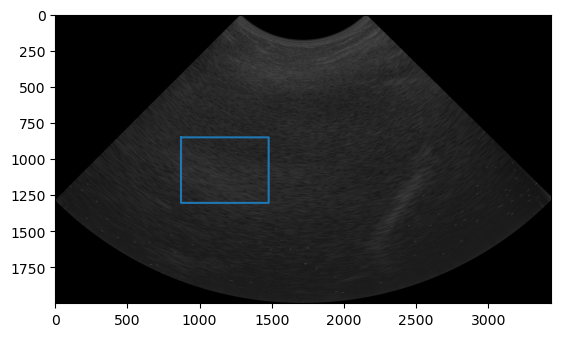

In [27]:
import matplotlib.pyplot as plt

plt.imshow(spectralData.scBmode)
plt.plot(scSplineX, scSplineY)

In [28]:
spectralData.drawCmaps()
spectralData.scanConvertCmaps()

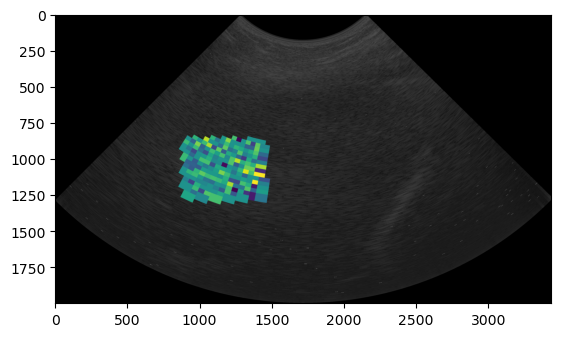

In [29]:
# Note cmap is near solid as image = phantom in this case
plt.imshow(spectralData.scMbfIm) 

In [35]:
# Ideally, minMbf=maxMbf=0. This issue has been proved to be a Python environtment issue when using our conda environment.
# To avoid this, use a pip-driven virtualenv from Python3.11.8
spectralData.minMbf, spectralData.maxMbf

(-2.733481102396731e-16, 2.605151560571131e-16)